In [12]:
import copy
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
from matplotlib.animation import FuncAnimation
from tqdm.auto import tqdm, trange

sys.path.append("../..")
from dataset import DataDataset, ICDataset, PDEDataset, PeriodicBCDataset
from loss import bc_derivative_mse, pde_mse
from model import Model
from preprocess import preprocess

from burgers.plot import plot_2d
from neural_rk.modules import count_trainable_param
from neural_rk.path import DATA_DIR, FIG_DIR

rng = np.random.default_rng(42)
device = torch.device("cuda:0")

# Data
### Notations
- $N_x$: Number of grid points at x-axis
- $N_y$: Number of grid points at y-axis
- $N$: number of all grid points. e.g., for 2D square lattice, $N = N_x * N_y$
- $E$: number of edges. e.g., for 2D square lattice with periodic B.C., $E = 2 * N$
- $S$: number of time steps

### Grid to Graph mapping
<pre>
3 -- 4 -- 5
|    |    |
0 -- 1 -- 2
</pre>
node: 0, 1, 2, 3, 4, 5

edge: (0, 1), (0, 3), (1, 2), (1, 4), (2, 5), (2, 0), (3, 4), (3, 0), (4, 5), (4, 1), (5, 3), (5, 2)


### Values of dataframe
- Optimized for GNN. Need to do pre-processing for others
- All values except network_type are torch.Tensor type with float32 precision

1. network_type: Nx_Ny. e.g., 100_100 if N_x=100 and N_y=100
2. edge_index: [2, $E$], which node is connected to which node
3. node_attr: [$N$, 2], all ones. If 1D burgers equation, node_attr[:, 1] = 0
4. edge_attr: [$E$, 2], distance of each edges.\
   edge_attr[:, 0]: nonzero for x-axis edge, edge_attr[:, 1]: nonzero for y-axis edge
5. glob_attr: [1, 2], [[nu, nu]] where nu is diffusion term of burgers equation.\
   If 1D burgers equation, [[nu, 0]]
6. dts: [$S$, 1], dt of each time step
7. trajectories: [$S+1$, $N$, 2], u, v value of each time step, each node. Length is $S+1$ since it contains initial condition

In [14]:
df.head()

network_type                                         edge_index  \
0      100_100  [[tensor(0), tensor(0), tensor(1), tensor(1), ...   
1      100_100  [[tensor(0), tensor(0), tensor(1), tensor(1), ...   
2      100_100  [[tensor(0), tensor(0), tensor(1), tensor(1), ...   
3      100_100  [[tensor(0), tensor(0), tensor(1), tensor(1), ...   
4      100_100  [[tensor(0), tensor(0), tensor(1), tensor(1), ...   

                                           node_attr  \
0  [[tensor(1.), tensor(1.)], [tensor(1.), tensor...   
1  [[tensor(1.), tensor(1.)], [tensor(1.), tensor...   
2  [[tensor(1.), tensor(1.)], [tensor(1.), tensor...   
3  [[tensor(1.), tensor(1.)], [tensor(1.), tensor...   
4  [[tensor(1.), tensor(1.)], [tensor(1.), tensor...   

                                           edge_attr  \
0  [[tensor(0.0100), tensor(0.)], [tensor(0.), te...   
1  [[tensor(0.0100), tensor(0.)], [tensor(0.), te...   
2  [[tensor(0.0100), tensor(0.)], [tensor(0.), te...   
3  [[tensor(0.0100), tensor(0.)], [tensor(0.), te...   
4  [[tensor(0.0100), tensor(0.)], [tensor(0.), te...   

                            glob_attr  \
0  [[tensor(0.0100), tensor(0.0100)]]   
1  [[tensor(0.0100), tensor(0.0100)]]   
2  [[tensor(0.0100), tensor(0.0100)]]   
3  [[tensor(0.0100), tensor(0.0100)]]   
4  [[tensor(0.0100), tensor(0.0100)]]   

                                                 dts  \
0  [[tensor(0.0010)], [tensor(0.0010)], [tensor(0...   
1  [[tensor(0.0010)], [tensor(0.0010)], [tensor(0...   
2  [[tensor(0.0010)], [tensor(0.0010)], [tensor(0...   
3  [[tensor(0.0010)], [tensor(0.0010)], [tensor(0...   
4  [[tensor(0.0010)], [tensor(0.0010)], [tensor(0...   

                                        trajectories  
0  [[[tensor(-0.3704), tensor(0.7340)], [tensor(-...  
1  [[[tensor(-0.0851), tensor(0.9721)], [tensor(-...  
2  [[[tensor(0.2211), tensor(-0.3222)], [tensor(0...  
3  [[[tensor(0.7051), tensor(0.3445)], [tensor(0....  
4  [[[tensor(-0.1313), tensor(0.6502)], [tensor(-...

In [2]:
test_id = "IC_train"
sample_idx = 0
exp_id = "PINN"

df = pd.read_pickle(DATA_DIR / f"burgers_{test_id}.pkl")
data = df.iloc[sample_idx]
data

network_type                                              100_100
edge_index      [[tensor(0), tensor(0), tensor(1), tensor(1), ...
node_attr       [[tensor(1.), tensor(1.)], [tensor(1.), tensor...
edge_attr       [[tensor(0.0100), tensor(0.)], [tensor(0.), te...
glob_attr                      [[tensor(0.0100), tensor(0.0100)]]
dts             [[tensor(0.0010)], [tensor(0.0010)], [tensor(0...
trajectories    [[[tensor(-0.3704), tensor(0.7340)], [tensor(-...
Name: 0, dtype: object

# PINN
#### NOTE : Full-batch training

In [3]:
xyt, field, nu = preprocess(data)  # Change to grid format

ic_sparsity = 1.0  # Sparsity of choosing grid points for initial condition
bc_sparsity = 0.1  # Sparsity of choosing grid points for boundary condition
pde_sparsity = 0.002  # Sparsity of choosing grid points for PDE condition
data_sparsity = 0.002  # Sparsity of choosing grid points for data condition
val_sparsity = 0.1  # Sparsity of choosing grid points for validation

ic_dataset = ICDataset(xyt, field, ic_sparsity, rng)
bc_dataset = PeriodicBCDataset(xyt, bc_sparsity, rng)
pde_dataset = PDEDataset(xyt, pde_sparsity, rng)
data_dataset = DataDataset(xyt, field, data_sparsity, rng)

val_dataset = DataDataset(xyt, field, val_sparsity, rng)

# Full-batch
ic_x = ic_dataset.x.to(device)
ic_y = ic_dataset.y.to(device)
ic_t = ic_dataset.t.to(device)
ic_field = ic_dataset.uv.to(device)

bc1_x = bc_dataset.x1.to(device)
bc1_y = bc_dataset.y1.to(device)
bc1_t = bc_dataset.t1.to(device)
bc2_x = bc_dataset.x2.to(device)
bc2_y = bc_dataset.y2.to(device)
bc2_t = bc_dataset.t2.to(device)

pde_x = pde_dataset.x.to(device)
pde_y = pde_dataset.y.to(device)
pde_t = pde_dataset.t.to(device)

data_x = data_dataset.x.to(device)
data_y = data_dataset.y.to(device)
data_t = data_dataset.t.to(device)
data_field = data_dataset.uv.to(device)

val_x = val_dataset.x.to(device)
val_y = val_dataset.y.to(device)
val_t = val_dataset.t.to(device)
val_field = val_dataset.uv.to(device)

In [4]:
model = Model(hidden_dim=64, bn_momentum=0.1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=4e-5)

print(f"Trainable parameters: {count_trainable_param(model)}")
print(f"Number of initial condtion points: {len(ic_dataset)}")
print(f"Number of boundary condtion points: {len(bc_dataset)}")
print(f"Number of pde points: {len(pde_dataset)}")
print(f"Number of data points: {len(data_dataset)}")

Trainable parameters: 17344
Number of initial condtion points: 10201
Number of boundary condtion points: 40220
Number of pde points: 40824
Number of data points: 40824


In [5]:
epochs = 3000

losses_ic: list[float] = []
losses_bc_value: list[float] = []
losses_bc_derivative: list[float] = []
losses_pde: list[float] = []
losses_data: list[float] = []
losses_train: list[float] = []
losses_test: list[float] = []

best_val_loss = 99999999.0
best_model_state_dict = copy.deepcopy(model.state_dict())

for epoch in trange(epochs):
    model.train()

    # Initial condition
    pred_ic = model(ic_x, ic_y, ic_t)
    loss_ic = F.mse_loss(pred_ic, ic_field)

    # Boundary condition
    pred_bc1 = model(bc1_x, bc1_y, bc1_t)
    pred_bc2 = model(bc2_x, bc2_y, bc2_t)

    loss_bc_value = F.mse_loss(pred_bc1, pred_bc2)
    loss_bc_derivative = bc_derivative_mse(
        bc1_x, bc1_y, bc1_t, pred_bc1, bc2_x, bc2_y, bc2_t, pred_bc2
    )

    # PDE condition
    pde_pred = model(pde_x, pde_y, pde_t)
    loss_pde = pde_mse(pde_x, pde_y, pde_t, pde_pred, nu)

    # Data condition
    data_pred = model(data_x, data_y, data_t)
    loss_data = F.mse_loss(data_pred, data_field)

    # Combining the loss functions
    loss = (
        1.0 * loss_ic
        + 10.0 * loss_bc_value
        + 1.0 * loss_bc_derivative
        + 1.0 * loss_pde
        + 0.0 * loss_data
    )

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    # Validation
    with torch.no_grad():
        model.eval()
        val_pred = model(val_x, val_y, val_t)
        loss_val = F.mse_loss(val_pred, val_field).item()
    losses_ic.append(loss_ic.item())
    losses_bc_value.append(loss_bc_value.item())
    losses_bc_derivative.append(loss_bc_derivative.item())
    losses_pde.append(loss_pde.item())
    losses_data.append(loss_data.item())
    losses_train.append(loss.item())
    losses_test.append(loss_val)

    # Save best model
    if loss_val >= best_val_loss:
        continue
    best_val_loss = loss_val
    best_model_state_dict = copy.deepcopy(model.state_dict())
    tqdm.write(f"{epoch}: train loss={loss.item():.4e}, val loss={loss_val:.4e}")

# Load best model state
last_model_state_dict = copy.copy(model.state_dict())
model.load_state_dict(best_model_state_dict)

  0%|          | 0/3000 [00:00<?, ?it/s]

0: train loss=2.7093e+00, val loss=1.0222e-01


<All keys matched successfully>

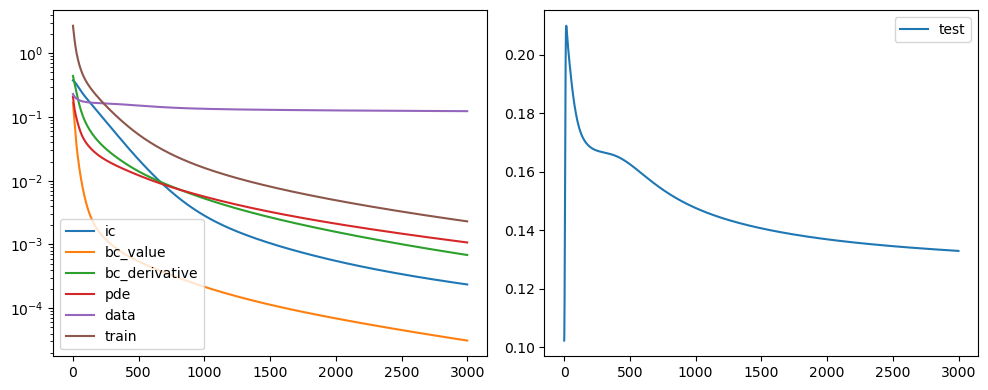

In [7]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 4), ncols=2)

ax1.plot(losses_ic, label="ic")
ax1.plot(losses_bc_value, label="bc_value")
ax1.plot(losses_bc_derivative, label="bc_derivative")
ax1.plot(losses_pde, label="pde")
ax1.plot(losses_data, label="data")
ax1.plot(losses_train, label="train")

ax1.legend()
ax1.set_yscale("log")

ax2.plot(losses_test, label="test")
ax2.legend()

fig.tight_layout()
fig.show()

In [8]:
# exp_id = 2
# result_dir = Path("result") / f"{exp_id}"

# result_dir.mkdir()
# checkpoint = {
#     "best_model_state_dict": model.state_dict(),
#     "ic": losses_ic,
#     "bc_value": losses_bc_value,
#     "bc_derivative": losses_bc_derivative,
#     "pde": losses_pde,
#     "data": losses_data,
#     "train": losses_train,
#     "test": losses_test,
# }
# torch.save(checkpoint, result_dir / "model.pth")


# checkpoint = torch.load(result_dir / "model.pth")
# model.load_state_dict(checkpoint["best_model_state_dict"])
# losses_ic = checkpoint["ic"]
# losses_bc_value = checkpoint["bc_value"]
# losses_bc_derivative = checkpoint["bc_derivative"]
# losses_pde = checkpoint["pde"]
# losses_data = checkpoint["data"]
# losses_train = checkpoint["train"]
# losses_test = checkpoint["test"]

# Test

In [8]:
model.load_state_dict(last_model_state_dict)

<All keys matched successfully>

In [9]:
num_batch = 4
num_steps, Ny, Nx, _ = field.shape  # [S+1, Ny+1, Nx+1]
Ny -= 1
Nx -= 1

pred_trajectories = []
with torch.no_grad():
    model.eval()

    for batch in range(num_batch):
        start = int(num_steps / num_batch * batch)
        end = int(num_steps / num_batch * (batch + 1)) if batch < num_batch - 1 else num_steps

        xyt_batch = xyt[:, :, start:end].reshape(-1, 3, 1).to(device)
        prediction = model(xyt_batch[:, 0], xyt_batch[:, 1], xyt_batch[:, 2])

        # [Ny+1, Nx+1, batch_step, 2]
        pred_trajectories.append(prediction.reshape(Ny + 1, Nx + 1, -1, 2))

# [S+1, Ny+1, Nx+1, 2]
pred_trajectory = torch.cat(pred_trajectories, dim=2).permute(2, 0, 1, 3).cpu().numpy()
true_trajectory = field.cpu().numpy()

In [10]:
error = true_trajectory - pred_trajectory
print(f"MAE={np.abs(error).mean():.4e}, in range {error.min(), error.max()}")

MAE=2.5599e-01, in range (-1.0021611, 1.002595)


In [15]:
# Best overall
error = true_trajectory - pred_trajectory
print(f"MAE={np.abs(error).mean():.4e}, in range {error.min(), error.max()}")

MAE=8.0588e-02, in range (-0.41972405, 0.49775845)


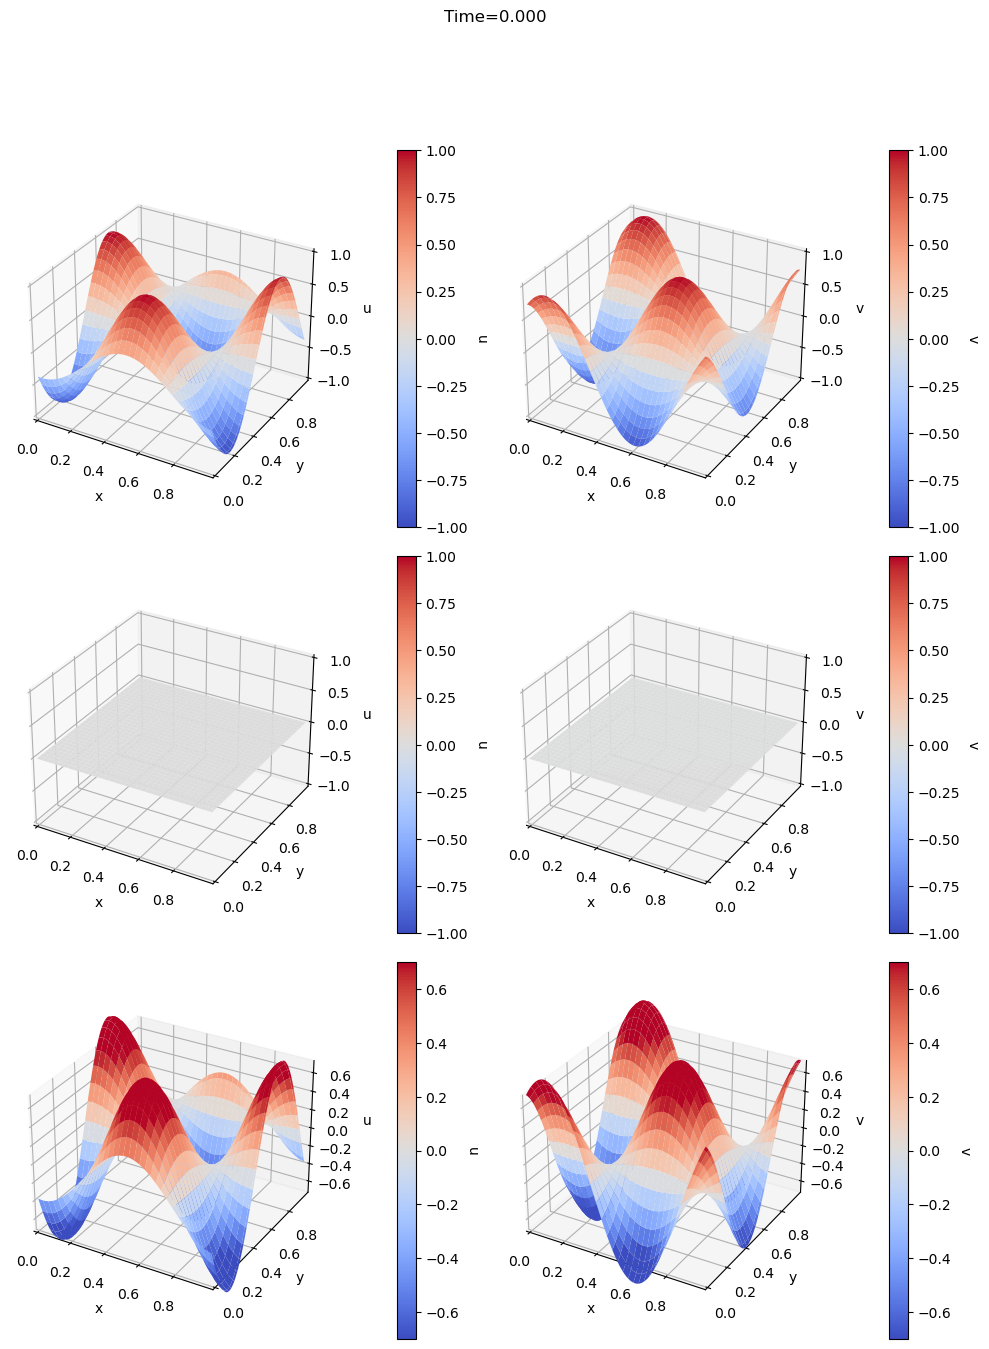

In [11]:
skip_frame = 10
position = xyt[:, :, 0, :2].numpy()
time = xyt[0, 0, :, 2].numpy()

fig = plt.figure(figsize=(10, 15))
ax1 = fig.add_subplot(321, projection="3d")
ax2 = fig.add_subplot(322, projection="3d")
ax3 = fig.add_subplot(323, projection="3d")
ax4 = fig.add_subplot(324, projection="3d")
ax5 = fig.add_subplot(325, projection="3d")
ax6 = fig.add_subplot(326, projection="3d")

ax1.set_title("True")
sf1, sf2 = plot_2d(ax1, ax2, position, true_trajectory[0], to_periodic=False)
cbar1 = ax1.figure.colorbar(sf1, ax=ax1, shrink=0.6, pad=0.15)
cbar1.ax.set_ylabel("u", rotation=-90, va="bottom")
cbar2 = ax2.figure.colorbar(sf2, ax=ax2, shrink=0.6, pad=0.15)
cbar2.ax.set_ylabel("v", rotation=-90, va="bottom")


ax3.set_title("Pred")
sf3, sf4 = plot_2d(ax3, ax4, position, pred_trajectory[0], to_periodic=False)
cbar3 = ax3.figure.colorbar(sf3, ax=ax3, shrink=0.6, pad=0.15)
cbar3.ax.set_ylabel("u", rotation=-90, va="bottom")
cbar4 = ax4.figure.colorbar(sf4, ax=ax4, shrink=0.6, pad=0.15)
cbar4.ax.set_ylabel("v", rotation=-90, va="bottom")

ax5.set_title("Error")
sf5, sf6 = plot_2d(ax5, ax6, position, error[0], to_periodic=False, lim=(-0.7, 0.7))
cbar5 = ax5.figure.colorbar(sf5, ax=ax5, shrink=0.6, pad=0.15)
cbar5.ax.set_ylabel("u", rotation=-90, va="bottom")
cbar6 = ax6.figure.colorbar(sf6, ax=ax6, shrink=0.6, pad=0.15)
cbar6.ax.set_ylabel("v", rotation=-90, va="bottom")
fig.tight_layout()


def update(frame: int) -> None:
    frame *= skip_frame
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()
    ax5.clear()
    ax6.clear()
    plot_2d(ax1, ax2, position, true_trajectory[frame], to_periodic=False)
    plot_2d(ax3, ax4, position, pred_trajectory[frame], to_periodic=False)
    plot_2d(ax5, ax6, position, error[frame], to_periodic=False, lim=(-0.7, 0.7))
    fig.suptitle(f"Time={time[frame]:.3f}")
    fig.tight_layout()


anim = FuncAnimation(
    fig, update, frames=int(len(pred_trajectory) / skip_frame), interval=50
)
# anim.save(str(FIG_DIR / f"burgers_{test_id}_{sample_idx}_{exp_id}.gif"))
anim.save("temp.gif")